# Food Demand Forecast

Your client is a meal delivery company which operates in multiple cities. They have various fulfillment centers in these cities for dispatching meal orders to their customers. The client wants you to help these centers with demand forecasting for upcoming weeks so that these centers will plan the stock of raw materials accordingly.

The replenishment of majority of raw materials is done on weekly basis and since the raw material is perishable, the procurement planning is of utmost importance. Secondly, staffing of the centers is also one area wherein accurate demand forecasts are really helpful. Given the following information, the task is to predict the demand for the next 10 weeks (Weeks: 146-155) for the center-meal combinations in the test set:  

Historical data of demand for a product-center combination (Weeks: 1 to 145)
Product(Meal) features such as category, sub-category, current price and discount
Information for fulfillment center like center area, city information etc.
 

**Data Dictionary**
1.	Weekly Demand data (train.csv): Contains the historical demand data for all centers, test.csv contains all the following features except the target variable 

Variable|Definition
:-------|:---------
id      | Unique ID
week	| Week No
center_id|Unique ID for fulfillment center
meal_id	  | Unique ID for Meal
checkout_price|Final price including discount, taxes & delivery charges
base_price	   | Base price of the meal
emailer_for_promotion|	Emailer sent for promotion of meal
homepage_featured	  |  Meal featured at homepage
num_orders	           | (Target) Orders Count

2.	fulfilment_center_info.csv: Contains information for each fulfilment center

Variable	|    Definition
:---------|:---------
center_id	|    Unique ID for fulfillment center
city_code	 |   Unique code for city
region_code	  |  Unique code for region
center_type	  |  Anonymized center type
op_area	      |  Area of operation (in km^2)
 
3.	meal_info.csv: Contains information for each meal being served

Variable	|    Definition
:---------|:---------
meal_id	  |      Unique ID for the meal
category	|    Type of meal (beverages/snacks/soups….)
cuisine	    |    Meal cuisine (Indian/Italian/…)



In [46]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform

In [47]:
# loading the datasets
weekly_demand = pd.read_csv('D:/Projects/End-to-End Food Demand Forecasting/notebook/data/train.csv')
fullfil_centers = pd.read_csv('D:/Projects/End-to-End Food Demand Forecasting/notebook/data/fulfilment_center_info.csv')
meal_info = pd.read_csv('D:/Projects/End-to-End Food Demand Forecasting/notebook/data/meal_info.csv')
test = pd.read_csv('D:/Projects/End-to-End Food Demand Forecasting/notebook/data/test.csv')

In [48]:
# Displaying the first few rows of the weekly demand dataset to understand its structure
weekly_demand.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [49]:
# Checking the data types and non-null counts in the weekly demand dataset
weekly_demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 31.3 MB


In [50]:
# Generating summary statistics for numerical columns in the weekly demand dataset
weekly_demand.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,456548.0,1.250096e+06,144354.822378,1000000.00,1124998.75,1250183.50,1375140.25,1499999.00
week,456548.0,7.476877e+01,41.524956,1.00,39.00,76.00,111.00,145.00
center_id,456548.0,8.210580e+01,45.975046,10.00,43.00,76.00,110.00,186.00
meal_id,456548.0,2.024337e+03,547.420920,1062.00,1558.00,1993.00,2539.00,2956.00
checkout_price,456548.0,3.322389e+02,152.939723,2.97,228.95,296.82,445.23,866.27
base_price,456548.0,3.541566e+02,160.715914,55.35,243.50,310.46,458.87,866.27
emailer_for_promotion,456548.0,8.115247e-02,0.273069,0.00,0.00,0.00,0.00,1.00
homepage_featured,456548.0,1.091999e-01,0.311890,0.00,0.00,0.00,0.00,1.00
num_orders,456548.0,2.618728e+02,395.922798,13.00,54.00,136.00,324.00,24299.00


In [51]:
# checking for null values in weekly demand dataset
weekly_demand.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
dtype: int64

In [52]:
fullfil_centers.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [53]:
# Checking the data types and non-null counts in the fulfillment centers dataset
fullfil_centers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   center_id    77 non-null     int64  
 1   city_code    77 non-null     int64  
 2   region_code  77 non-null     int64  
 3   center_type  77 non-null     object 
 4   op_area      77 non-null     float64
dtypes: float64(1), int64(3), object(1)
memory usage: 3.1+ KB


In [54]:
# Generating summary statistics for numerical columns in the weekly demand dataset
fullfil_centers.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
center_id,77.0,83.142857,46.090219,10.0,50.0,77.0,110.0,186.0
city_code,77.0,600.662338,66.720274,456.0,553.0,596.0,651.0,713.0
region_code,77.0,56.493506,18.126473,23.0,34.0,56.0,77.0,93.0
op_area,77.0,3.985714,1.106406,0.9,3.5,3.9,4.4,7.0


In [55]:
# Checking for missing values in the fullfilment canter dataset
fullfil_centers.isnull().sum()

center_id      0
city_code      0
region_code    0
center_type    0
op_area        0
dtype: int64

In [56]:
meal_info.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [57]:
# Checking the data types and non-null counts in the meal info dataset
meal_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   meal_id   51 non-null     int64 
 1   category  51 non-null     object
 2   cuisine   51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB


In [58]:
# checking for null values in meal info dataset
meal_info.isnull().sum()

meal_id     0
category    0
cuisine     0
dtype: int64

In [59]:
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [60]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32573 entries, 0 to 32572
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     32573 non-null  int64  
 1   week                   32573 non-null  int64  
 2   center_id              32573 non-null  int64  
 3   meal_id                32573 non-null  int64  
 4   checkout_price         32573 non-null  float64
 5   base_price             32573 non-null  float64
 6   emailer_for_promotion  32573 non-null  int64  
 7   homepage_featured      32573 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 2.0 MB


In [61]:
# Generating summary statistics for numerical columns in the test dataset
test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,32573.0,1.248476e+06,144158.048324,1000085.00,1123969.00,1247296.00,1372971.00,1499996.00
week,32573.0,1.504778e+02,2.864072,146.00,148.00,150.00,153.00,155.00
center_id,32573.0,8.190173e+01,45.950455,10.00,43.00,76.00,110.00,186.00
meal_id,32573.0,2.032068e+03,547.199004,1062.00,1558.00,1993.00,2569.00,2956.00
checkout_price,32573.0,3.418544e+02,153.893886,67.90,214.43,320.13,446.23,1113.62
base_price,32573.0,3.564936e+02,155.150101,89.24,243.50,321.13,455.93,1112.62
emailer_for_promotion,32573.0,6.643539e-02,0.249045,0.00,0.00,0.00,0.00,1.00
homepage_featured,32573.0,8.135572e-02,0.273385,0.00,0.00,0.00,0.00,1.00


In [62]:
# checking for null values in test dataset
test.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
dtype: int64

In [63]:
# Adding a placeholder column for predictions in the test dataset
test['num_orders'] = 0

In [64]:
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1028232,146,55,1885,158.11,159.11,0,0,0
1,1127204,146,55,1993,160.11,159.11,0,0,0
2,1212707,146,55,2539,157.14,159.14,0,0,0
3,1082698,146,55,2631,162.02,162.02,0,0,0
4,1400926,146,55,1248,163.93,163.93,0,0,0


In [65]:
# merging all the data sets into single datset for analysis
data = pd.concat([weekly_demand, test], axis=0)
data = data.merge(fullfil_centers, on='center_id', how='left')
data = data.merge(meal_info, on='meal_id', how='left')
data.shape

(489121, 15)

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489121 entries, 0 to 489120
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     489121 non-null  int64  
 1   week                   489121 non-null  int64  
 2   center_id              489121 non-null  int64  
 3   meal_id                489121 non-null  int64  
 4   checkout_price         489121 non-null  float64
 5   base_price             489121 non-null  float64
 6   emailer_for_promotion  489121 non-null  int64  
 7   homepage_featured      489121 non-null  int64  
 8   num_orders             489121 non-null  int64  
 9   city_code              489121 non-null  int64  
 10  region_code            489121 non-null  int64  
 11  center_type            489121 non-null  object 
 12  op_area                489121 non-null  float64
 13  category               489121 non-null  object 
 14  cuisine                489121 non-nu

In [67]:
data.isnull().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
city_code                0
region_code              0
center_type              0
op_area                  0
category                 0
cuisine                  0
dtype: int64

The null values in num_order column are equal to the number of rows in the test dataset (containing data from week 146-155) loaded earlier. These rows will be left out of the analysis since we want to predict the demand for the next 10-week period with the help of a prediction model.

# Feature Engineering


In [68]:
# Creating a new feature for discount amount
data['discount_amount'] = round(data['base_price']-data['checkout_price'],4)

In [69]:
# Creating a new feature for discount percentage
data['discount_percent'] = round(((data['base_price']-data['checkout_price'])/data['base_price'])*100,4)

In [25]:
# Creating a binary feature to indicate whether a discount was applied
# data['discount y/n'] = [1 if x>0 else 0 for x in (data['base_price']-data['checkout_price'])]

In [26]:
# Creating a feature to compare the change in weekly prices
data['weekly_base_price_change'] = round(data.groupby(['meal_id', 'center_id'])['base_price'].diff(),4)

# Fill NaN values (e.g., for the first week) with 0
data['weekly_base_price_change'] = data['weekly_base_price_change'].fillna(0)

In [27]:
# Creating feature that calculates weekly changes in checkout price
data['weekly_checkout_price_change'] = round(data.groupby(['meal_id', 'center_id'])['checkout_price'].diff(),4)

# Fill NaN values (e.g., for the first week) with 0
data['weekly_checkout_price_change'] = data['weekly_checkout_price_change'].fillna(0)

In [70]:
# Extract week of the year
data['week_of_year'] = data['week'].apply(lambda x: x % 52 if x % 52 != 0 else 52)

In [127]:
# Extract quarter of the year
data['quarter'] = data['week_of_year'].apply(lambda x: (x - 1) // 13 + 1)

In [128]:
data['month'] = data['week_of_year'].apply(lambda x: (x-1) // 4 + 1)

In [ ]:
# Counting the number of occurrences of each quarter
# data['quarter'].value_counts()

In [32]:
# Calculating 4-week rolling average for checkout_price and base_price
# data['4_week_avg_checkout_price'] = round(data.groupby(['meal_id', 'center_id'])['checkout_price'].transform(lambda x: x.rolling(window=4, min_periods=1).mean()),4)
# data['4_week_avg_base_price'] = round(data.groupby(['meal_id', 'center_id'])['base_price'].transform(lambda x: x.rolling(window=4, min_periods=1).mean()),4)

In [33]:
data.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'city_code',
       'region_code', 'center_type', 'op_area', 'category', 'cuisine',
       'discount_amount', 'discount_percent', 'weekly_base_price_change',
       'weekly_checkout_price_change', 'week_of_year'],
      dtype='object')

In [71]:
# #Creating lag feature
# data = data.sort_values(['meal_id','center_id','week'])
# for lag in [1,2,3,4,10,15]:
#     data[f'lag_{lag}'] = data.groupby(['meal_id','center_id'])['num_orders'].shift(lag).fillna(0)

# rolling_window = data.groupby(['meal_id','center_id'])['num_orders'].shift(1).rolling(window=4, min_periods=1)

# data['rolling_4_week_mean'] = round(rolling_window.mean().fillna(0),2)


# Calculate the average checkout price for each category in each week

avg_price_cat = data.groupby(['week','category'])['base_price'].apply(lambda x: x.mean()).reindex(data.set_index(['week', 'category']).index).values

data['price_vs_category_avg'] = round(data['base_price'] - avg_price_cat,2)


In [72]:
data['emailer_for_promotion'] = data['emailer_for_promotion'].astype('object')
data['homepage_featured'] = data['homepage_featured'].astype('object')
data['city_code'] = data['city_code'].astype('object')
data['region_code'] = data['region_code'].astype('object')
data['center_id'] = data['center_id'].astype('object')
data['meal_id'] = data['meal_id'].astype('object')

In [73]:
# data['base_price_max'] = data.groupby('meal_id')['base_price'].transform('max')
# data['base_price_min'] = data.groupby('meal_id')['base_price'].transform('min')
# data['base_price_mean'] = round(data.groupby('meal_id')['base_price'].transform('mean'),4)
# data['meal_price_max'] = data.groupby('meal_id')['checkout_price'].transform('max')
# data['meal_price_min'] = data.groupby('meal_id')['checkout_price'].transform('min')
# data['meal_price_mean'] = round(data.groupby('meal_id')['checkout_price'].transform('mean'),4)

# data = data.sort_values(['meal_id','center_id','week'])
            
# base_price_expanding_window = data.groupby(['meal_id','center_id'])['base_price'].expanding(min_periods=1)
# data['expanding_base_price_mean'] = round(base_price_expanding_window.mean().reset_index(level=[0,1],drop=True),4)
# data['expanding_base_price_max'] = base_price_expanding_window.max().reset_index(drop=True)
# data['expanding_base_price_min'] = base_price_expanding_window.min().reset_index(drop=True)

# checkout_price_expanding_window = data.groupby(['meal_id','center_id'])['checkout_price'].expanding(min_periods=1)
# data['expanding_checkout_price_mean'] = round(checkout_price_expanding_window.mean().reset_index(level=[0,1],drop=True),4)
# data['expanding_checkout_price_max'] = checkout_price_expanding_window.max().reset_index(drop=True)
# data['expanding_checkout_price_min'] = checkout_price_expanding_window.min().reset_index(drop=True)

# data['center_price_rank'] = data.groupby(['meal_id','center_id'])['base_price'].rank(method='dense').astype('int64')


# data['meal_price_rank'] = data.groupby('meal_id')['base_price'].rank(method='dense').astype('int64')


# Cyclical "Week of Year" Features (helps models understand seasonality)
data['week_sin'] = np.sin(2 * np.pi * data['week_of_year'] / 52)
data['week_cos'] = np.cos(2 * np.pi * data['week_of_year'] / 52)

# Creating Exponential Moving Average (EMA) Features
# data = data.sort_values(['meal_id','center_id','week'])
# grouped = data.groupby(['meal_id','center_id'])

# spans = [1,2,4,5,10,15]

# for span in spans:
#     ewma_orders = grouped['num_orders'].shift(1).ewm(span=span, adjust=True,min_periods=1).mean()
#     data[f'ewma_{span}_week_orders'] = round(ewma_orders.fillna(0),4)

In [37]:
data.isnull().sum()

id                               0
week                             0
center_id                        0
meal_id                          0
checkout_price                   0
base_price                       0
emailer_for_promotion            0
homepage_featured                0
num_orders                       0
city_code                        0
region_code                      0
center_type                      0
op_area                          0
category                         0
cuisine                          0
discount_amount                  0
discount_percent                 0
weekly_base_price_change         0
weekly_checkout_price_change     0
week_of_year                     0
lag_1                            0
lag_2                            0
lag_3                            0
lag_4                            0
lag_10                           0
lag_15                           0
price_vs_category_avg            0
base_price_max                   0
base_price_min      

In [74]:
data.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'city_code',
       'region_code', 'center_type', 'op_area', 'category', 'cuisine',
       'discount_amount', 'discount_percent', 'week_of_year',
       'price_vs_category_avg', 'week_sin', 'week_cos'],
      dtype='object')

In [39]:
data.shape

(489121, 49)

In [40]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,489121.0,1.249988e+06,144342.144768,1000000.0000,1.124937e+06,1.249977e+06,1.374988e+06,1.499999e+06
week,489121.0,7.981061e+01,44.343325,1.0000,4.200000e+01,8.100000e+01,1.180000e+02,1.550000e+02
checkout_price,489121.0,3.328793e+02,153.022073,2.9700,2.280100e+02,2.997600e+02,4.452300e+02,1.113620e+03
base_price,489121.0,3.543123e+02,160.352168,55.3500,2.435000e+02,3.114300e+02,4.588100e+02,1.112620e+03
num_orders,489121.0,2.444334e+02,388.044503,0.0000,4.100000e+01,1.220000e+02,2.980000e+02,2.429900e+04
op_area,489121.0,4.083865e+00,1.092163,0.9000,3.600000e+00,4.000000e+00,4.500000e+00,7.000000e+00
discount_amount,489121.0,2.143298e+01,47.976701,-185.3000,-1.000000e+00,3.000000e-02,5.850000e+00,8.205900e+02
discount_percent,489121.0,5.628960e+00,11.309361,-72.7898,-1.473000e-01,1.870000e-02,2.597100e+00,9.906090e+01
weekly_base_price_change,489121.0,2.752427e-02,11.955528,-343.3500,-1.000000e+00,0.000000e+00,1.000000e+00,7.770000e+02
weekly_checkout_price_change,489121.0,1.024435e-01,43.647805,-821.5900,-2.000000e+00,0.000000e+00,2.000000e+00,8.720900e+02


In [41]:
data.info(0)

<class 'pandas.core.frame.DataFrame'>
Index: 489121 entries, 2370 to 358495
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   id                             489121 non-null  int64  
 1   week                           489121 non-null  int64  
 2   center_id                      489121 non-null  object 
 3   meal_id                        489121 non-null  object 
 4   checkout_price                 489121 non-null  float64
 5   base_price                     489121 non-null  float64
 6   emailer_for_promotion          489121 non-null  object 
 7   homepage_featured              489121 non-null  object 
 8   num_orders                     489121 non-null  int64  
 9   city_code                      489121 non-null  object 
 10  region_code                    489121 non-null  object 
 11  center_type                    489121 non-null  object 
 12  op_area                        4

In [42]:
data.isnull().sum()

id                               0
week                             0
center_id                        0
meal_id                          0
checkout_price                   0
base_price                       0
emailer_for_promotion            0
homepage_featured                0
num_orders                       0
city_code                        0
region_code                      0
center_type                      0
op_area                          0
category                         0
cuisine                          0
discount_amount                  0
discount_percent                 0
weekly_base_price_change         0
weekly_checkout_price_change     0
week_of_year                     0
lag_1                            0
lag_2                            0
lag_3                            0
lag_4                            0
lag_10                           0
lag_15                           0
price_vs_category_avg            0
base_price_max                   0
base_price_min      

In [130]:
# Filtering the dataset to include only data from weeks 1 to 145 for further analysis
datax = data[data['week'].isin(range(1,146))]

In [131]:
datax.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456548 entries, 2370 to 358495
Data columns (total 51 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   id                             456548 non-null  int64  
 1   week                           456548 non-null  int64  
 2   center_id                      456548 non-null  object 
 3   meal_id                        456548 non-null  object 
 4   checkout_price                 456548 non-null  float64
 5   base_price                     456548 non-null  float64
 6   emailer_for_promotion          456548 non-null  object 
 7   homepage_featured              456548 non-null  object 
 8   num_orders                     456548 non-null  int64  
 9   city_code                      456548 non-null  object 
 10  region_code                    456548 non-null  object 
 11  center_type                    456548 non-null  object 
 12  op_area                        4

Using data from week 1 to week 145 for further analysis.

# Exploratory Data Analysis (EDA)

<Axes: >

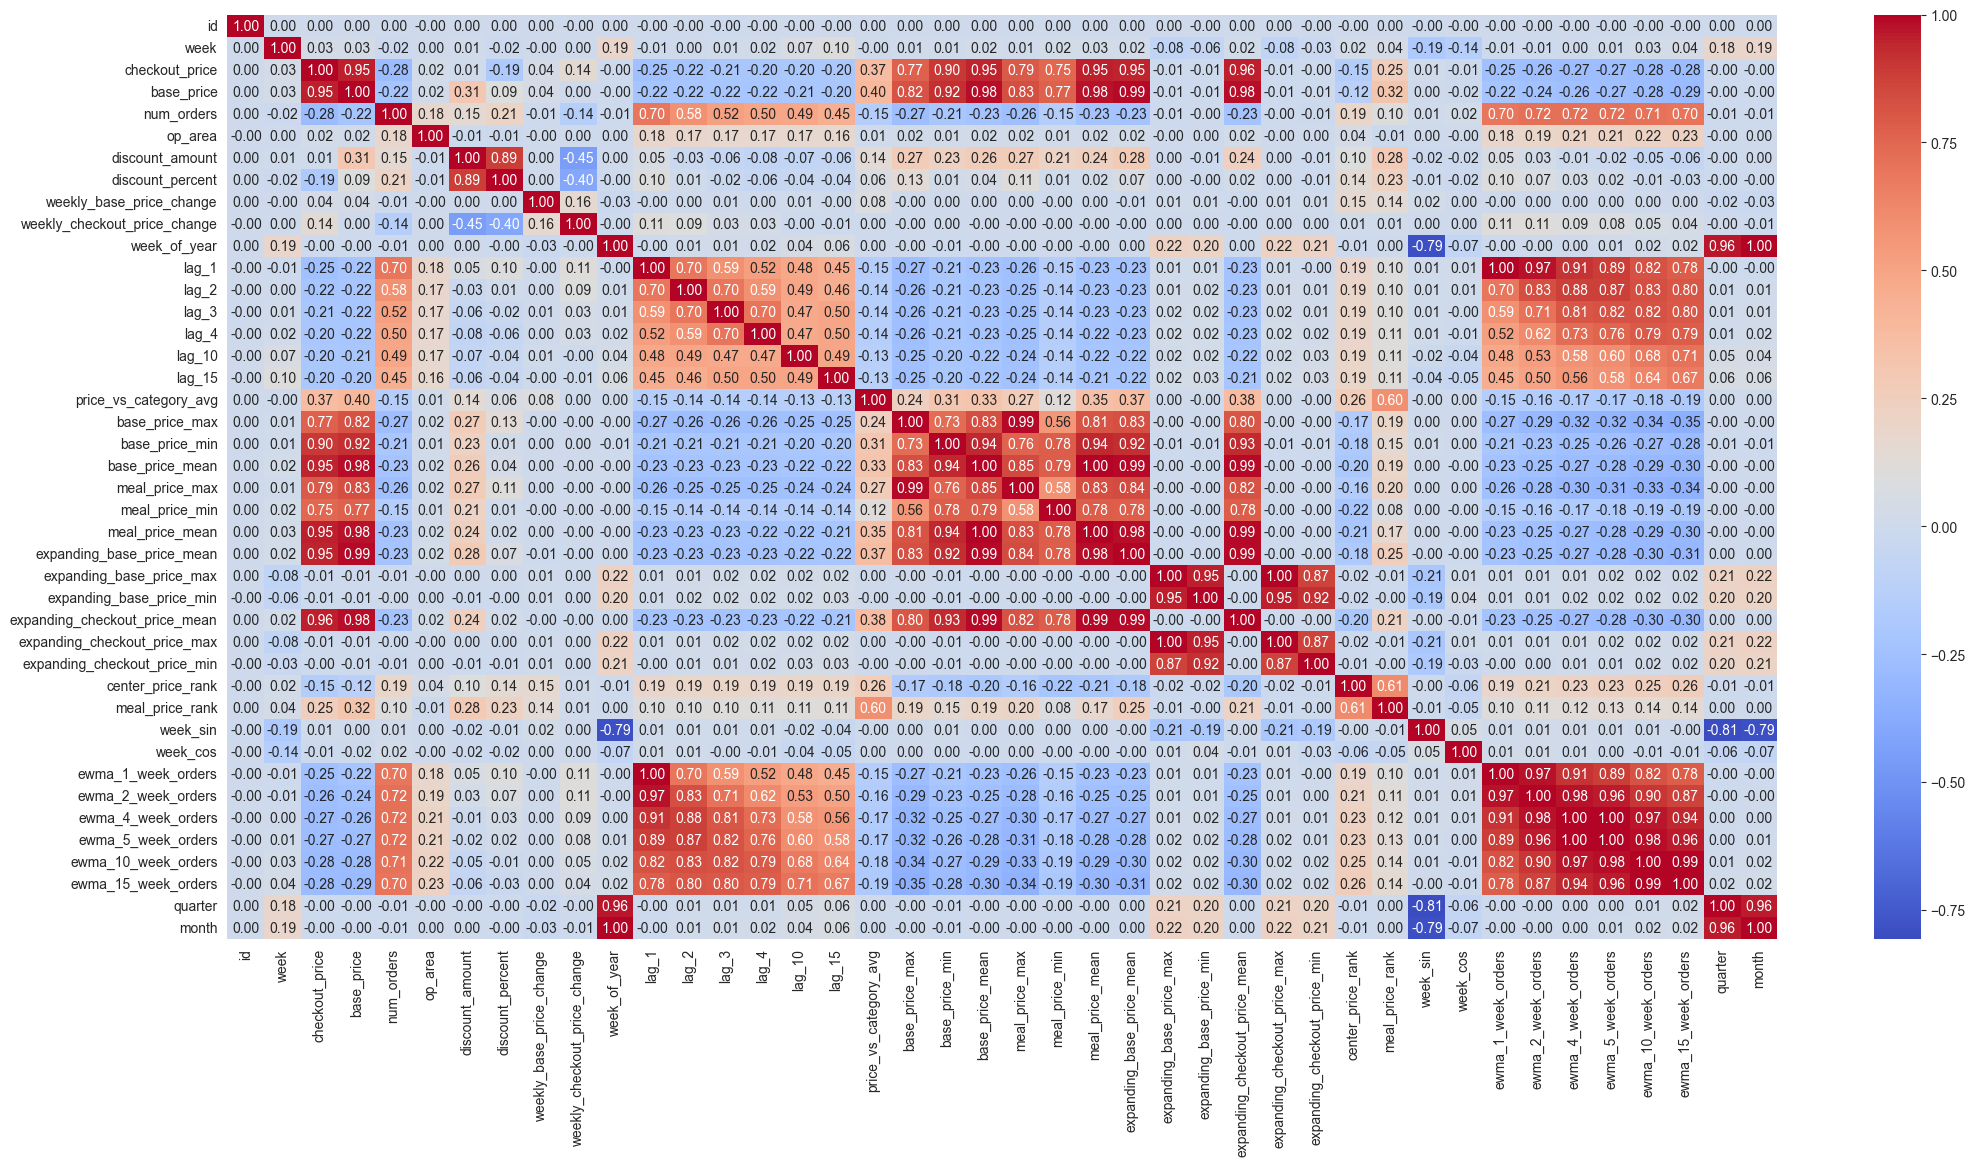

In [132]:
# Visualizing correlations between numerical features using a heatmap
plt.figure(figsize=(25, 12))
sns.heatmap(datax.corr(numeric_only=True), annot=True, cmap='coolwarm',fmt=".2f")

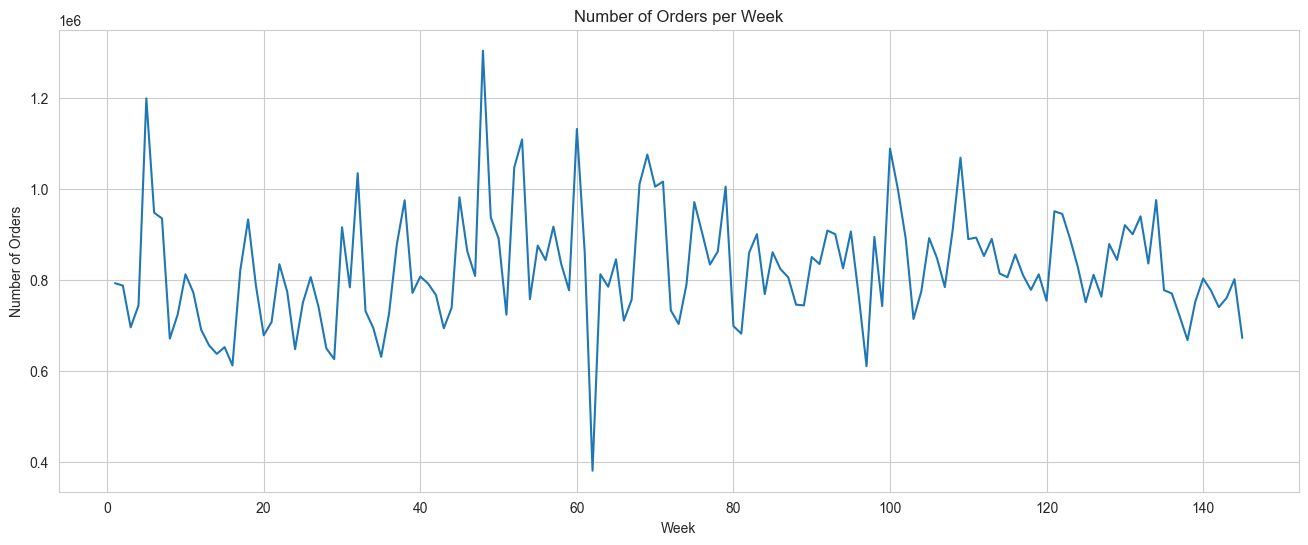

In [133]:
# Visualizing the trend of the number of orders per week
sns.set_style('whitegrid')
plt.figure(figsize=(16, 6))
sns.lineplot(x='week', y='num_orders', data=datax,estimator='sum',errorbar=None)
plt.title('Number of Orders per Week')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.show()

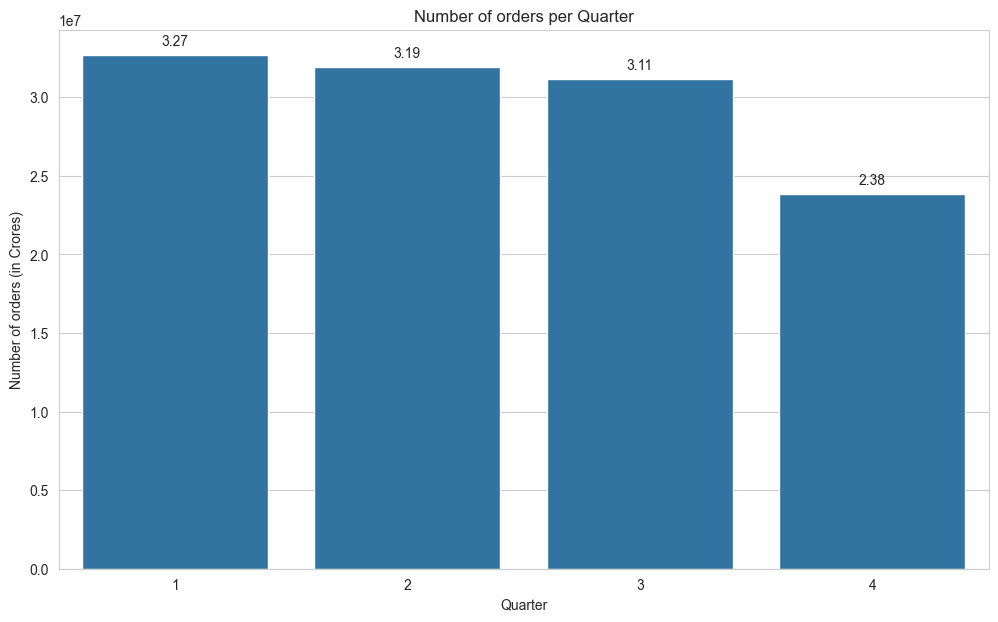

In [134]:
# Visualizing the trend of the number of orders per quarter
plt.figure(figsize=(12, 7))
a1 = sns.barplot(x='quarter', y='num_orders', data=datax, estimator='sum', errorbar=None)
plt.ylabel('Number of orders (in Crores)')
plt.xlabel('Quarter')
plt.title('Number of orders per Quarter')

# display data labels on bars
for p in a1.patches:
    value_in_crores = p.get_height() / 1e7  # Convert to crores
    a1.annotate(format(value_in_crores, '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
    
plt.show()


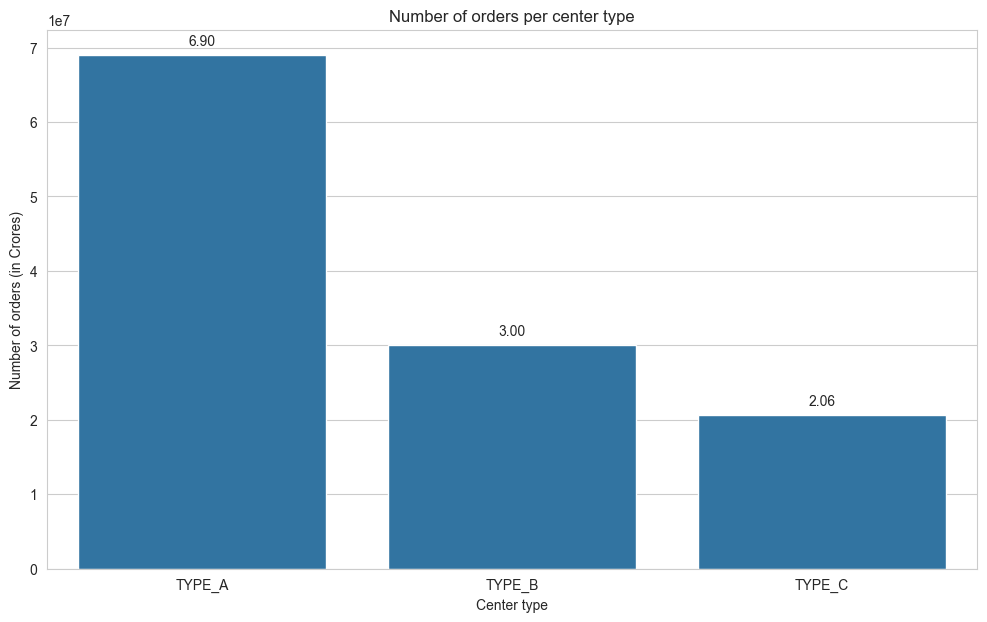

In [ ]:
# Display total number of orders for each Center type
plt.figure(figsize=(12, 7))
a1 = sns.barplot(x='center_type', y='num_orders', data=datax.groupby('center_type').num_orders.sum().sort_values(ascending=False).reset_index(),
                 errorbar=None)
plt.ylabel('Number of orders (in Crores)')
plt.xlabel('Center type')
plt.title('Number of orders per center type')

# display data labels on bars
for p in a1.patches:
    value_in_crores = p.get_height() / 1e7  # Convert to crores
    a1.annotate(format(value_in_crores, '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')
    
plt.show()


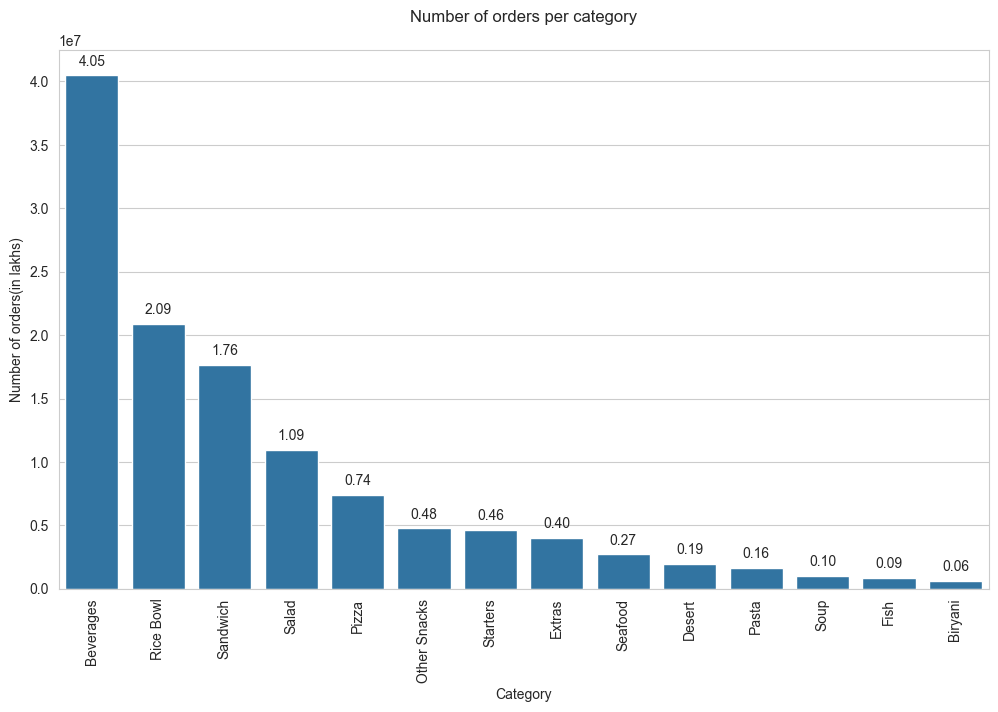

In [ ]:
# Display total number of orders for each meal category
sns.set_style('whitegrid')
plt.figure(figsize=(12, 7))
a2 = sns.barplot(x='category', y='num_orders', data=datax.groupby('category').num_orders.sum().sort_values(ascending=False).reset_index(),
                 errorbar=None)
plt.ylabel('Number of orders(in lakhs)')
plt.xlabel('Category')
plt.title('Number of orders per category',pad=20)
plt.xticks(rotation=90)

# display data labels on bars
for p in a2.patches:
    value_in_crores = p.get_height() / 1e7  # Convert to crores
    a2.annotate(format(value_in_crores, '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.show()

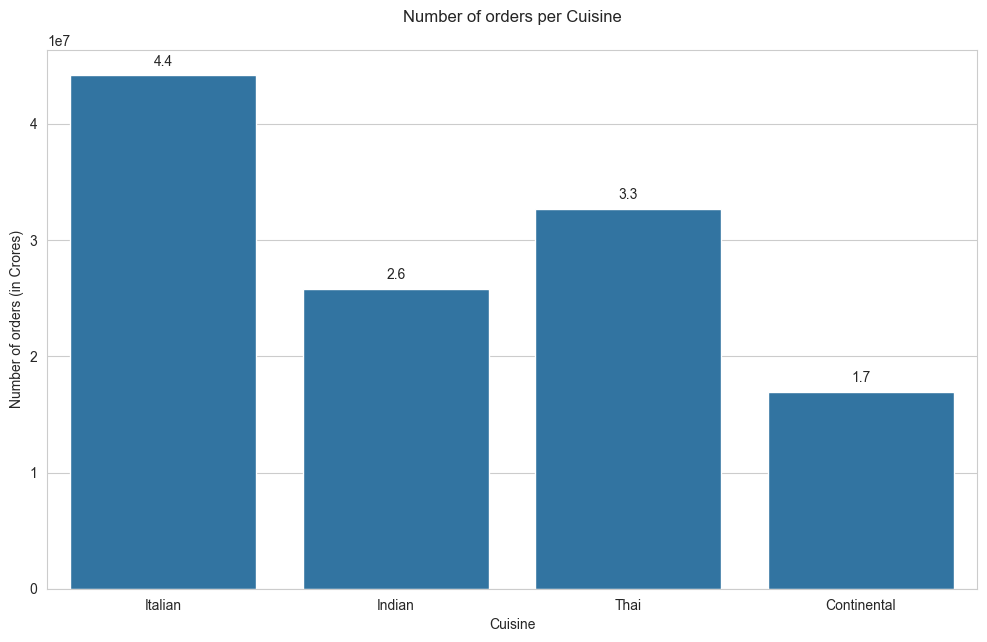

In [ ]:
# Visualizing the total number of orders for each cuisine type    
sns.set_style('whitegrid')
plt.figure(figsize=(12, 7))  # Adjust the width and height as needed
a3 = sns.barplot(x='cuisine', y='num_orders', data=datax,estimator=sum,errorbar=None)
plt.ylabel('Number of orders (in Crores)')
plt.xlabel('Cuisine')
plt.title('Number of orders per Cuisine', pad=20)

# Display data labels on bars
for p in a3.patches:
    value_in_crores = p.get_height() / 1e7  # Convert to crores
    a3.annotate(format(value_in_crores, '.1f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

# plt.xticks(rotation=90)
# plt.show()

Text(0.5, 1.0, 'Total Number of Orders for Each Category')

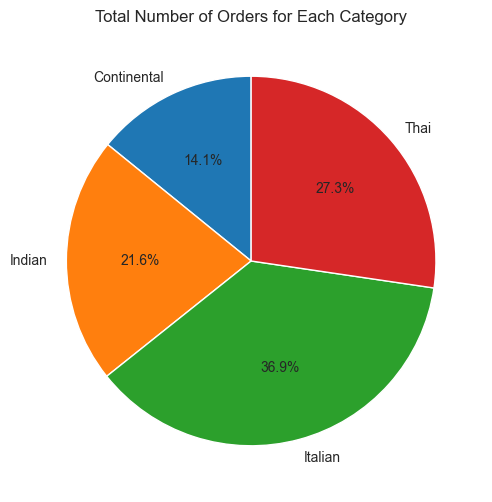

In [ ]:
# A pie chart to visualize the total number of orders for each cuisine type.
plt.figure(figsize=(6,6))
plt.pie(datax.groupby(['cuisine']).num_orders.sum(),
    labels=datax.groupby(['cuisine']).num_orders.sum().index,
    startangle=90,
    autopct='%1.1f%%',pctdistance=0.6,)
plt.title('Total Number of Orders for Each Category')

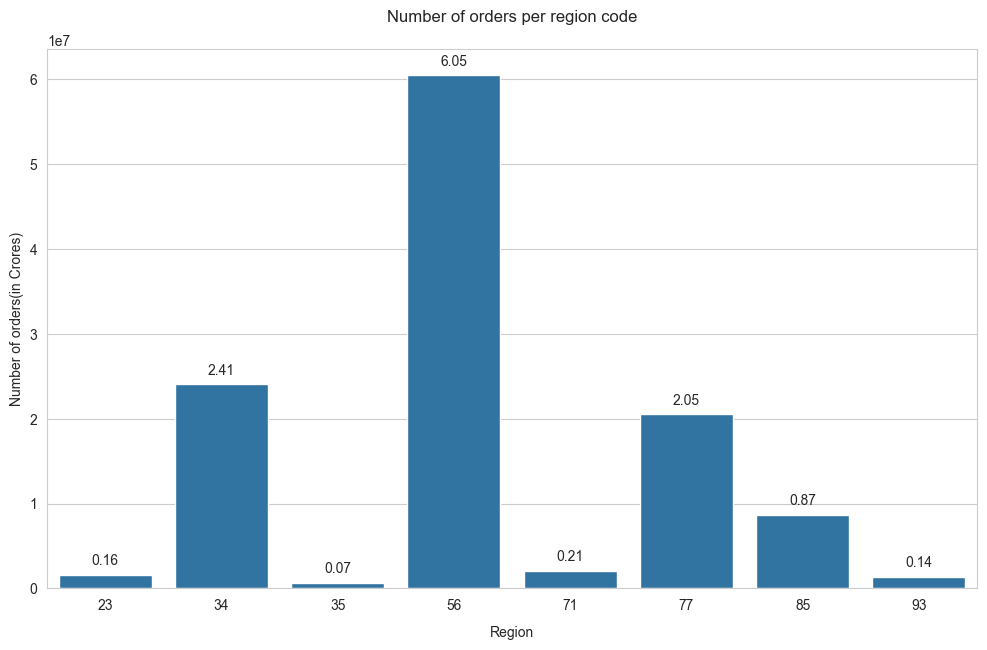

In [ ]:
# Display total number of orders for each region code.
plt.figure(figsize=(12, 7))
a4 = sns.barplot(x='region_code',y='num_orders',data=datax,estimator=sum,errorbar=None)
                 
plt.ylabel('Number of orders(in Crores)')
plt.xlabel('Region',labelpad=10)
plt.title('Number of orders per region code',pad=20)
for p in a4.patches:
    value_in_crores = p.get_height() / 1e7  # Convert to crores
    a4.annotate(format(value_in_crores, '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center', va = 'center', xytext = (0, 10),
                  textcoords = 'offset points')
plt.show()

Text(0.5, 0, 'City')

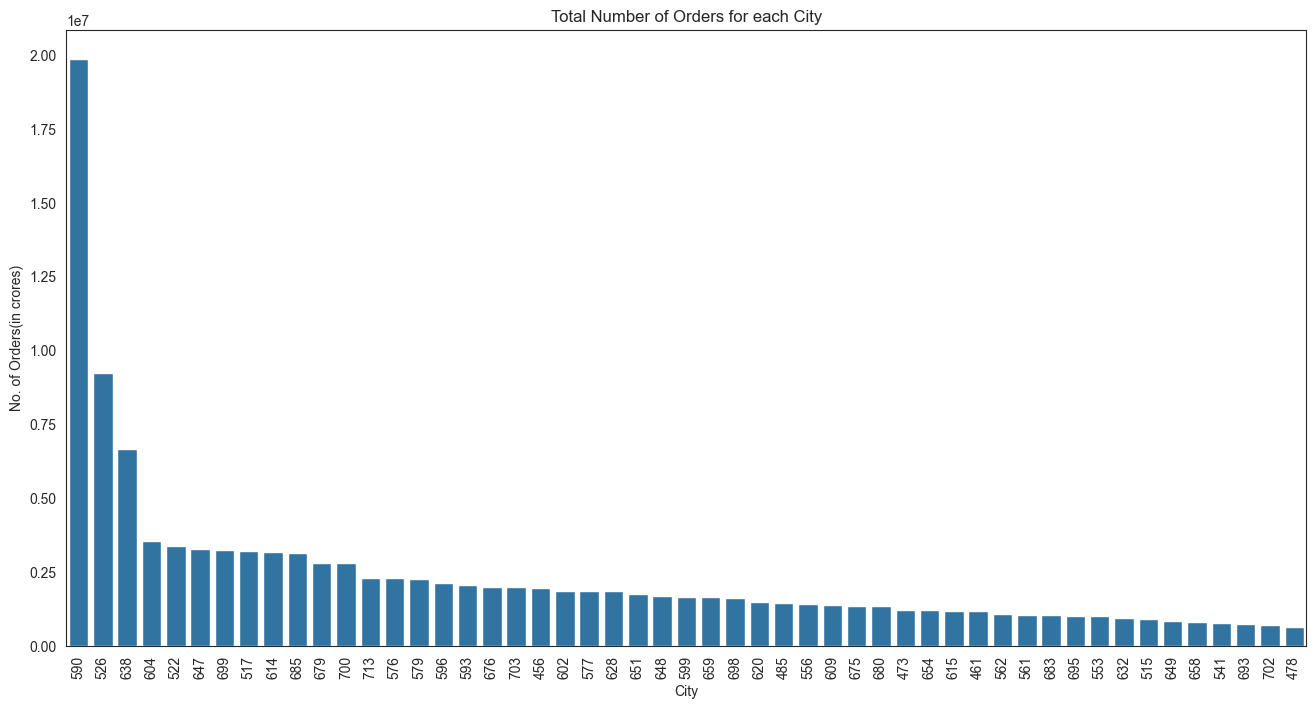

In [ ]:
# Visualizing the trend of the number of orders for each city.
fig=plt.figure(figsize=(16,8))
sns.set_style("white")
plt.xticks(rotation=90)
plt.title('Total Number of Orders for each City')
a5 = sns.barplot(y='num_orders', x='city_code', data=datax.groupby('city_code').num_orders.sum().sort_values(ascending=False).reset_index(),
            order=list(datax.groupby('city_code').num_orders.sum().sort_values(ascending=False).reset_index()['city_code'].values))
plt.ylabel('No. of Orders(in crores)')
plt.xlabel('City')

As per our observation from our barchart of the City against the number of orders. There the high significant difference between the Top 3 cities(590,526,638) which have the highest number of orders. Therefore, we will categorize the City with Highest No. of Orders as C1, City with 2nd Highest No. of Orders as C2 and City with 3rd Highest No. of Orders as C3 and the remaining cities will be categorized as CH4, since, they do not have much significant differences between the number of orders.

# Data Preprocessing

In [ ]:
# # Categorizing cities into four groups based on their order volume.
# city4={590:'C1', 526:'C2', 638:'C3'}
# data['city_cat']=data['city_code'].map(city4)
# data['city_cat']=data['city_cat'].fillna('C4')

In [ ]:
# data['city_cat'].value_counts()

city_cat
C4    362341
C1     58708
C2     46589
C3     21483
Name: count, dtype: int64

In [ ]:
data['region_code'].value_counts()

region_code
56    204911
34    124978
77    101300
85     32521
23      6883
71      6761
93      6133
35      5634
Name: count, dtype: int64

In [75]:
# Split data into train and test before encoding
train_df = data[data['week'].isin(range(1,136))] #for training the model
test_df = data[data['week'].isin(range(136,146))] #for testing the model
last_10week_df = data[data['week'].isin(range(146,156))] # for predicitions

In [76]:
data.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'city_code',
       'region_code', 'center_type', 'op_area', 'category', 'cuisine',
       'discount_amount', 'discount_percent', 'week_of_year',
       'price_vs_category_avg', 'week_sin', 'week_cos'],
      dtype='object')

In [86]:
numerical_columns = ['week','base_price','checkout_price','discount_amount','discount_percent',
                                  'week_of_year','week_sin','week_cos','price_vs_category_avg',
                                #   'center_price_rank','meal_price_rank'
                                ]

ohe_categorical_columns = ['emailer_for_promotion', 'homepage_featured','center_type', 'category','cuisine']

target_en_categorical_columns = ['center_id','region_code','city_code','meal_id']

In [50]:
# numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
# categorical_columns = data.select_dtypes(include=['object']).columns
# categorical_columns

In [79]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [87]:
# Define the numerical and categorical transformers
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# ohe_categorical_pipeline = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# Combine the transformers into a preprocessor
preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numerical_pipeline, numerical_columns),
                    # ('cat', ohe_categorical_pipeline, ohe_categorical_columns),
                    # ('target_cat',ce.TargetEncoder(), target_en_categorical_columns)
                ],
                remainder='passthrough'
            )

In [53]:
# target_column = np.log1p(data['num_orders'])

In [88]:
# Prepare X_train, y_train, X_test, y_test
X_train = train_df.drop(columns=['id','num_orders'], axis=1) 
y_train = np.log1p(train_df['num_orders'])
X_test = test_df.drop(columns=['id','num_orders'], axis=1)
y_test = np.log1p(test_df['num_orders'])

# Display the updated DataFrames
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)



X_train shape: (423727, 19)
X_test shape: (32821, 19)


In [89]:
X_train.columns


Index(['week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'city_code',
       'region_code', 'center_type', 'op_area', 'category', 'cuisine',
       'discount_amount', 'discount_percent', 'week_of_year',
       'price_vs_category_avg', 'week_sin', 'week_cos'],
      dtype='object')

In [90]:
X_train_transformed = preprocessor.fit_transform(X_train,y_train)
X_test_transformed = preprocessor.transform(X_test)

In [91]:
X_train_transformed

array([[-1.7752245264805457, -1.251824555869625, -1.2718120604954473,
        ..., 2.0, 'Beverages', 'Thai'],
       [-1.7752245264805457, -1.3541118365744769, -1.2718120604954473,
        ..., 2.0, 'Beverages', 'Thai'],
       [-1.7752245264805457, -1.353925407751807, -1.2846806742144201,
        ..., 2.0, 'Beverages', 'Thai'],
       ...,
       [1.6885105728131755, -0.09447442473525908, 0.05881566262880904,
        ..., 4.5, 'Salad', 'Italian'],
       [1.6885105728131755, -0.14835235448684256, -0.010883884772937471,
        ..., 4.5, 'Salad', 'Italian'],
       [1.6885105728131755, -0.3958676880515002, -0.25800046192458537,
        ..., 4.5, 'Salad', 'Italian']], shape=(423727, 19), dtype=object)

# Model 1 - Linear Regression

In [63]:
# importing the libraries for model building
from sklearn.linear_model import LinearRegression

In [64]:
# Initializing the Linear Regression model
lm = LinearRegression()

In [65]:
# Fitting the model on the training data
lm.fit(X_train_transformed, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [66]:
# Predicting on the test data
lm_predictions = lm.predict(X_test_transformed)

In [67]:
from sklearn import metrics

In [68]:
# Evaluating the model performance.
mae = metrics.mean_absolute_error(y_test,lm_predictions)
mse = metrics.mean_squared_error(y_test, lm_predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test, lm_predictions))
r2 = metrics.r2_score(y_test, lm_predictions)
print('Mae:',mae)
print('Mse:', mse)
print('Rmse: ',rmse)
print('R2:', r2)


Mae: 0.46145041247446833
Mse: 0.34156092924380344
Rmse:  0.5844321425484771
R2: 0.7413416693890426


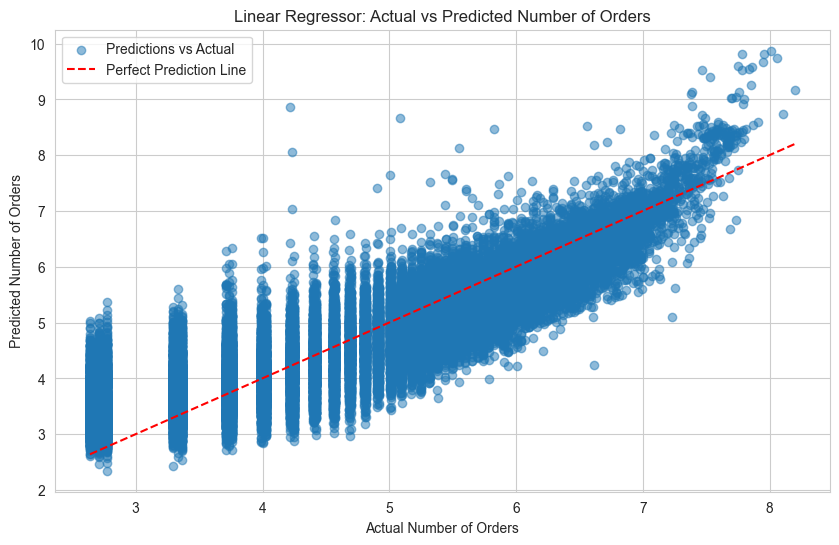

In [69]:
# Plotting Linear Regressor predictions vs Actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lm_predictions, alpha=0.5, label='Predictions vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')  # Diagonal line
plt.xlabel('Actual Number of Orders')
plt.ylabel('Predicted Number of Orders')
plt.title('Linear Regressor: Actual vs Predicted Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

# Model 4: Random Forest

In [86]:
from sklearn.ensemble import RandomForestRegressor

In [87]:
rfr = RandomForestRegressor(n_estimators=150,max_depth=9,max_features='sqrt',min_samples_leaf=3)

In [88]:
rfr.fit(X_train_transformed, y_train)

,n_estimators,150
,criterion,'squared_error'
,max_depth,9
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [89]:
rfr_predictions = rfr.predict(X_test_transformed)

In [90]:
y_test_normal = np.expm1(y_test)
actual_rfr_predictions = np.expm1(rfr_predictions)

In [91]:

mae = metrics.mean_absolute_error(y_test,rfr_predictions)
mse = metrics.mean_squared_error(y_test, rfr_predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test, rfr_predictions))
r2 = metrics.r2_score(y_test, rfr_predictions)
mape = metrics.mean_absolute_percentage_error(y_test, rfr_predictions)

print('Mae:',mae)
print('Mse:', mse)
print('Rmse: ',rmse)
print('R2:', r2)
print('Mape:', mape)

Mae: 0.37705810048538324
Mse: 0.24362396853929152
Rmse:  0.49358278792852117
R2: 0.8155076778286614
Mape: 0.09134027608254705


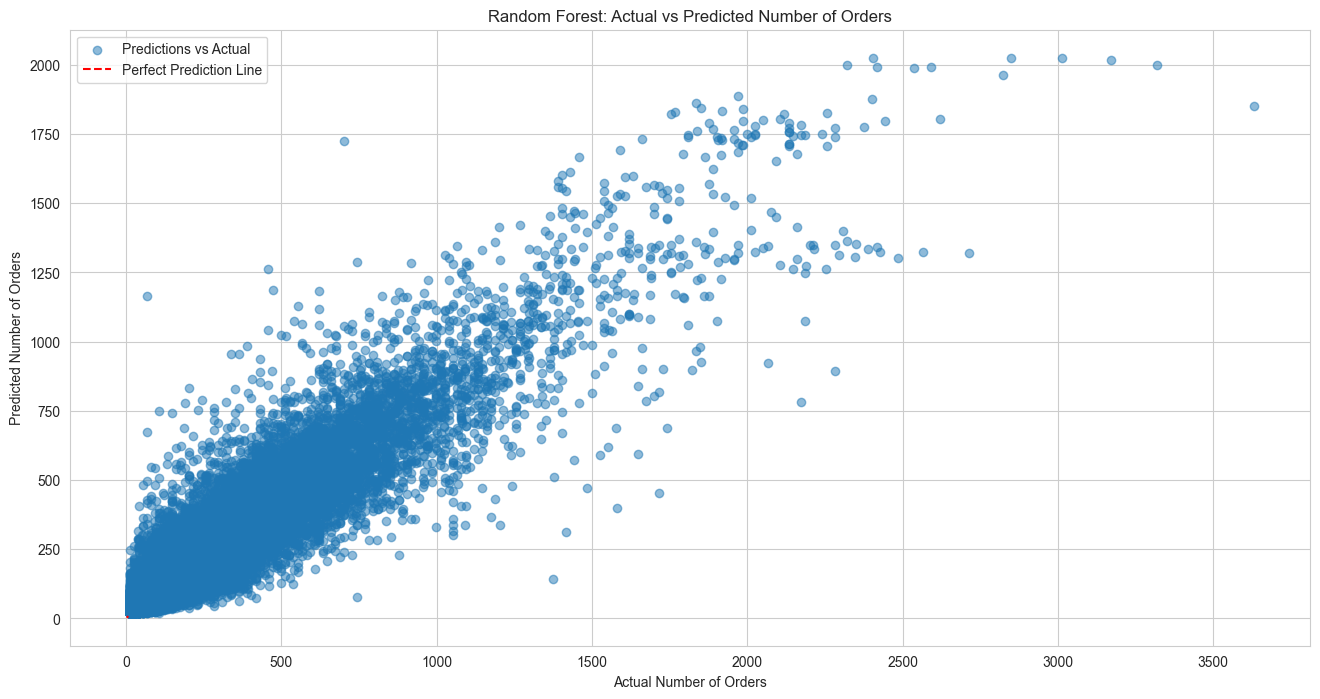

In [92]:
# Plotting Random Forest predictions vs Actual values
plt.figure(figsize=(16, 8))
plt.scatter(y_test_normal, actual_rfr_predictions, alpha=0.5, label='Predictions vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')  # Diagonal line
plt.xlabel('Actual Number of Orders')
plt.ylabel('Predicted Number of Orders')
plt.title('Random Forest: Actual vs Predicted Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

# Model 5: XGBoost

In [93]:
import xgboost as xgb

In [121]:
xgb_regressor = xgb.XGBRegressor(max_depth=9,n_estimators=100,learning_rate=0.1,tree_method='exact')

In [122]:
xgb_regressor.fit(X_train_transformed, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [123]:
xgb_predictions = xgb_regressor.predict(X_test_transformed)

In [124]:
actual_xgb_predictions = np.expm1(xgb_predictions)

In [125]:
mse = metrics.mean_squared_error(y_test_normal, actual_xgb_predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test_normal, actual_xgb_predictions))
r2 = metrics.r2_score(y_test_normal, actual_xgb_predictions)
mape = metrics.mean_absolute_percentage_error(y_test_normal, actual_xgb_predictions)

print('Mae:',mae)
print('Mse:', mse)
print('Rmse: ',rmse)
print('R2:', r2)
print('Mape:', mape)

Mae: 0.37705810048538324
Mse: 18277.847752205304
Rmse:  135.19559072767612
R2: 0.7610865666742272
Mape: 0.44055945548451914


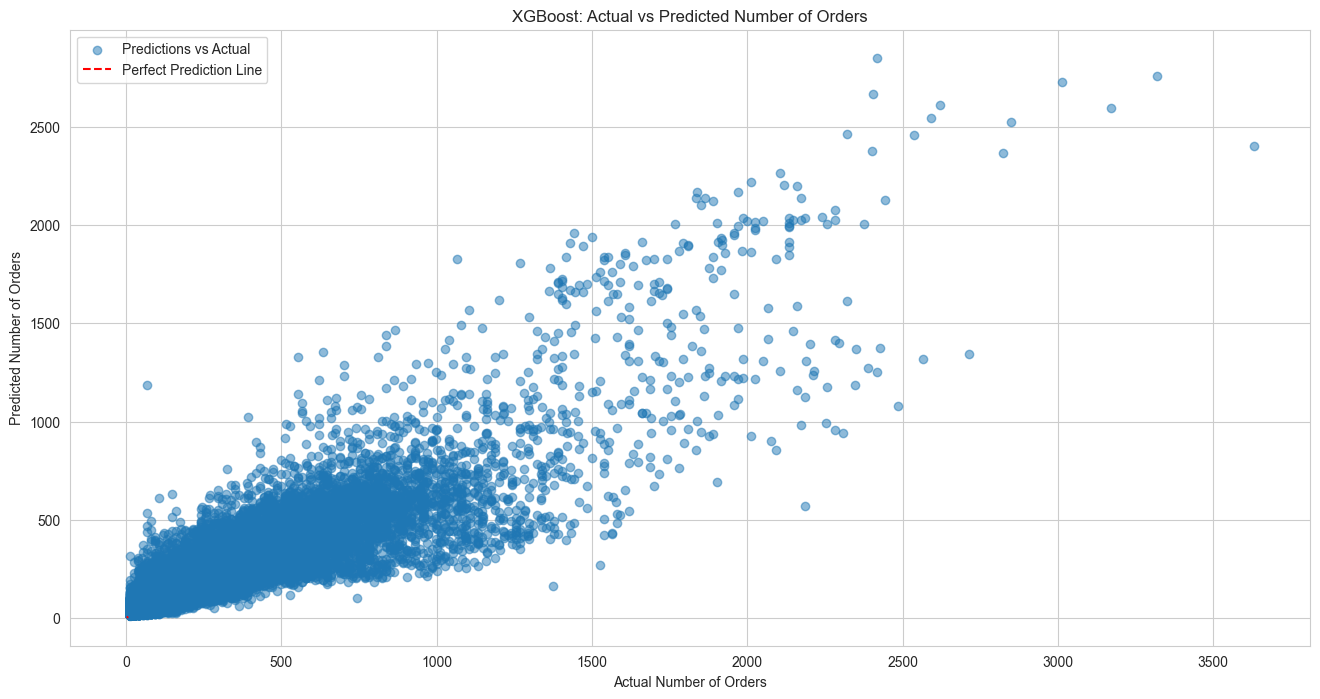

In [126]:
# Plotting XGBoost predictions vs Actual values
plt.figure(figsize=(16, 8))
plt.scatter(y_test_normal, actual_xgb_predictions, alpha=0.5, label='Predictions vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')  # Diagonal line
plt.xlabel('Actual Number of Orders')
plt.ylabel('Predicted Number of Orders')
plt.title('XGBoost: Actual vs Predicted Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

# Model 6: light GBM

In [102]:
import lightgbm as lgb

In [103]:
lgb_regressor = lgb.LGBMRegressor(n_estimators=150,max_depth=9,learnign_rate=0.13,reg_lambda=3)

In [104]:
lgb_regressor.fit(X_train_transformed, y_train)

[LightGBM] [Warning] Unknown parameter: learnign_rate
[LightGBM] [Warning] Unknown parameter: learnign_rate
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7491
[LightGBM] [Info] Number of data points in the train set: 423727, number of used features: 67
[LightGBM] [Info] Start training from score 4.892793


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,9
,learning_rate,0.1
,n_estimators,150
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [105]:
lgb_predictions = lgb_regressor.predict(X_test_transformed)

[LightGBM] [Warning] Unknown parameter: learnign_rate


d:\Projects\End-to-End Food Demand Forecasting\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [106]:
actual_lgb_predictions = np.expm1(lgb_predictions)

In [ ]:
mse = metrics.mean_squared_error(y_test_normal, actual_lgb_predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test_normal, actual_lgb_predictions))
r2 = metrics.r2_score(y_test_normal, actual_lgb_predictions)
mape = metrics.mean_absolute_percentage_error(y_test_normal, actual_lgb_predictions)

print('Mae:',mae)
print('Mse:', mse)
print('Rmse:',rmse)
print('R2:', r2)
print('Mape:', mape)

Mae: 0.37705810048538324
Mse: 14802.024280278634
Rmse:  121.663570062195
R2: 0.8065197561049748
Mape: 0.4309641506973989


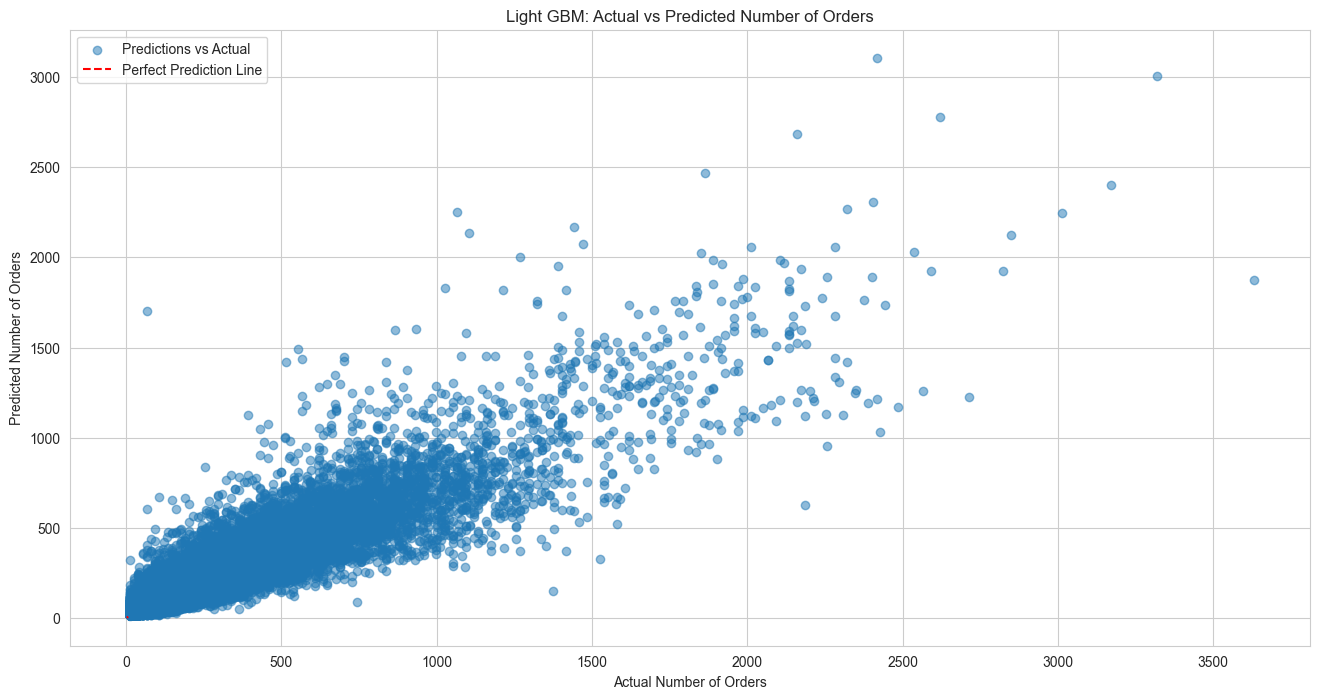

In [108]:
# Plotting XGBoost predictions vs Actual values
plt.figure(figsize=(16, 8))
plt.scatter(y_test_normal, actual_lgb_predictions, alpha=0.5, label='Predictions vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')  # Diagonal line
plt.xlabel('Actual Number of Orders')
plt.ylabel('Predicted Number of Orders')
plt.title('Light GBM: Actual vs Predicted Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

# model 7: Cat boost

In [109]:
import catboost as cb

In [110]:
cb_regressor = cb.CatBoostRegressor(iterations=2000,learning_rate=0.01,max_depth=9,l2_leaf_reg=8,loss_function='RMSE')

In [111]:
cb_regressor.fit(X_train_transformed, y_train)

0:	learn: 1.1981114	total: 167ms	remaining: 5m 34s
1:	learn: 1.1892043	total: 195ms	remaining: 3m 15s
2:	learn: 1.1803468	total: 221ms	remaining: 2m 27s
3:	learn: 1.1716577	total: 247ms	remaining: 2m 3s
4:	learn: 1.1630091	total: 273ms	remaining: 1m 48s
5:	learn: 1.1544911	total: 299ms	remaining: 1m 39s
6:	learn: 1.1461140	total: 327ms	remaining: 1m 32s
7:	learn: 1.1378463	total: 353ms	remaining: 1m 27s
8:	learn: 1.1296630	total: 378ms	remaining: 1m 23s
9:	learn: 1.1215636	total: 408ms	remaining: 1m 21s
10:	learn: 1.1136068	total: 443ms	remaining: 1m 20s
11:	learn: 1.1056928	total: 470ms	remaining: 1m 17s
12:	learn: 1.0978823	total: 498ms	remaining: 1m 16s
13:	learn: 1.0901527	total: 529ms	remaining: 1m 15s
14:	learn: 1.0825659	total: 555ms	remaining: 1m 13s
15:	learn: 1.0750925	total: 581ms	remaining: 1m 12s
16:	learn: 1.0676620	total: 611ms	remaining: 1m 11s
17:	learn: 1.0603894	total: 636ms	remaining: 1m 10s
18:	learn: 1.0531346	total: 661ms	remaining: 1m 8s
19:	learn: 1.0459920	tot

In [112]:
cb_predictions = cb_regressor.predict(X_test_transformed)

In [118]:
actual_cb_predictions = np.expm1(cb_predictions)

In [119]:
mse = metrics.mean_squared_error(y_test_normal, actual_cb_predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test_normal, actual_cb_predictions))
r2 = metrics.r2_score(y_test_normal, actual_cb_predictions)
mape = metrics.mean_absolute_percentage_error(y_test_normal, actual_cb_predictions)

print('Mae:',mae)
print('Mse:', mse)
print('Rmse: ',rmse)
print('R2:', r2)
print('Mape:', mape)

Mae: 0.37705810048538324
Mse: 11558.683377895086
Rmse:  107.51131744097961
R2: 0.848914118993837
Mape: 0.4280305551370902


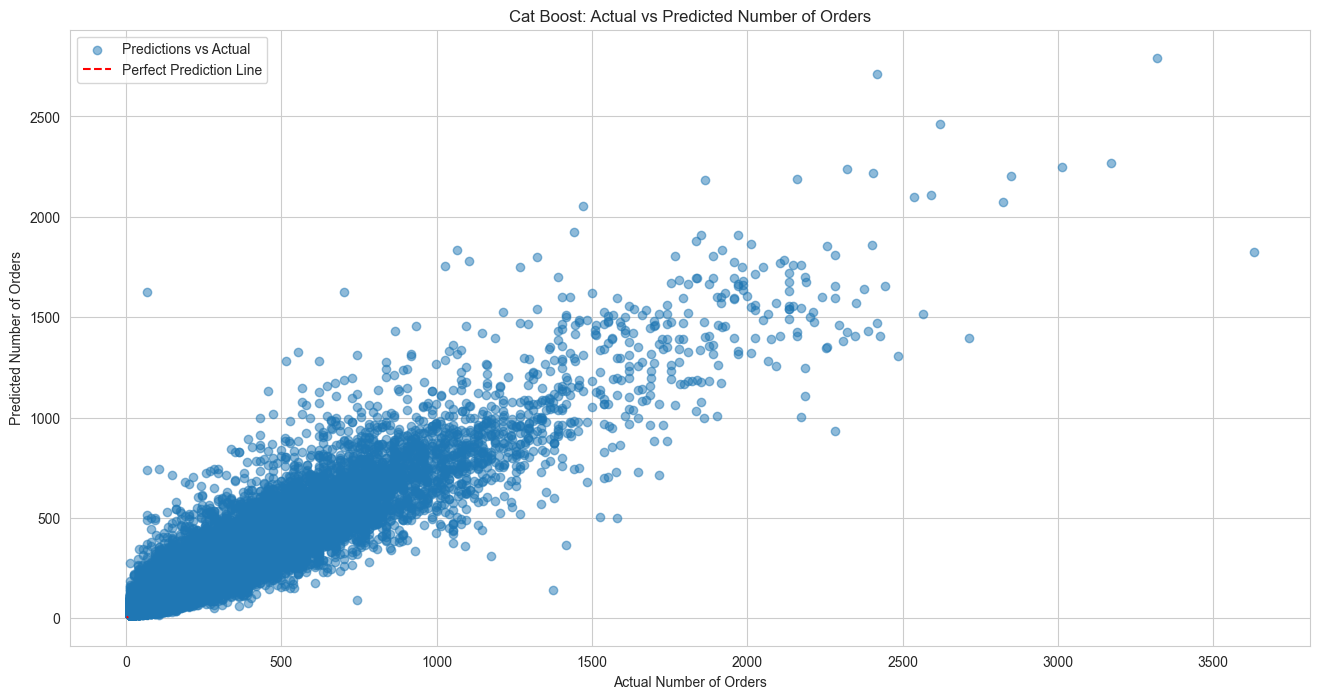

In [120]:
# Plotting XGBoost predictions vs Actual values
plt.figure(figsize=(16, 8))
plt.scatter(y_test_normal, actual_cb_predictions, alpha=0.5, label='Predictions vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction Line')  # Diagonal line
plt.xlabel('Actual Number of Orders')
plt.ylabel('Predicted Number of Orders')
plt.title('Cat Boost: Actual vs Predicted Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

Since randon forest regressor gave the best result i.e low Rmse and high R sqaure value. Hence, randon forest regressor will be used to make submision for the Analytics Vidhya Food DEmand Prediction hackathon.

In [116]:
last_10week_df_transformed = preprocessor.transform(last_10week_df.drop(columns=['num_orders'], axis=1).reset_index(drop=True))

In [117]:
last_10week_predictions_rfr = rfr.predict(last_10week_df.drop(['num_orders', 'id'], axis=1).reset_index(drop=True))

d:\Projects\End-to-End Food Demand Forecasting\.venv\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


ValueError: could not convert string to float: 'TYPE_B'

In [ ]:
last_10week_df_transformed = preprocessor.transform(last_10week_df.drop(['num_orders', 'id'], axis=1).reset_index(drop=True))
last_10week_df_transformed

In [ ]:
last_10week_predictions_xgb = xgb_regressor.predict(last_10week_df_transformed)

In [ ]:
last_10week_predictions_xgb

In [ ]:
last_10week_predictions_rfr = rfr.predict(last_10week_df_transformed)
last_10week_predictions_rfr

array([884.09780485, 626.64112576, 433.23673261, ...,  41.87957232,
        40.53242408,  39.99167536])

In [ ]:
# Result=pd.DataFrame(last_10week_predictions_rfr)
# Result[Result<0] = 0 
# # Result=np.expm1(Result).astype('int64')
# Submission = pd.DataFrame(columns=['id', 'num_orders'])
# Submission['id'] = data[data['week'].isin(range(146,156))]['id']
# Submission['num_orders'] = Result.values
# Submission.to_csv('Result Random forest.csv', index=False)

# Testing feaatures

In [ ]:
datay = data.copy()

In [ ]:
datay['base_price_max'] = datay.groupby('meal_id')['base_price'].transform('max')
datay['base_price_min'] = datay.groupby('meal_id')['base_price'].transform('min')
datay['base_price_mean'] = round(datay.groupby('meal_id')['base_price'].transform('mean'),4)
datay['meal_price_max'] = datay.groupby('meal_id')['checkout_price'].transform('max')
datay['meal_price_min'] = datay.groupby('meal_id')['checkout_price'].transform('min')
datay['meal_price_mean'] = round(datay.groupby('meal_id')['checkout_price'].transform('mean'),4)
datay.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,lag_10,rolling_4_week_mean,price_vs_category_avg,base_price_max,base_price_min,base_price_mean,meal_price_max,meal_price_min,meal_price_mean,center_cat_count
2370,1436842,1,10,1062,181.39,181.39,0,0,865,590,...,0.0,0.00,-57.11,195.03,143.62,176.1012,195.03,90.21,171.4709,1859
5273,1205013,2,10,1062,183.36,182.36,0,0,782,590,...,0.0,865.00,-55.17,195.03,143.62,176.1012,195.03,90.21,171.4709,1859
8175,1447751,3,10,1062,184.36,182.36,0,0,851,590,...,0.0,823.50,-55.26,195.03,143.62,176.1012,195.03,90.21,171.4709,1859
11064,1014968,4,10,1062,182.36,183.36,0,0,1202,590,...,0.0,832.67,-54.11,195.03,143.62,176.1012,195.03,90.21,171.4709,1859
13918,1003563,5,10,1062,183.39,181.39,0,0,958,590,...,0.0,925.00,-53.39,195.03,143.62,176.1012,195.03,90.21,171.4709,1859


In [ ]:
datay.groupby('meal_id')['base_price'].max()

meal_id
1062     195.03
1109     347.32
1198     340.53
1207     515.13
1216     641.23
1230     534.53
1247     505.43
1248     407.46
1311     340.53
1438     272.63
1445     866.27
1525     321.13
1543     602.43
1558     728.53
1571     680.03
1727     505.43
1754     376.42
1770     486.03
1778     195.03
1803     340.53
1847     272.63
1878     321.13
1885     179.51
1902     486.03
1962     728.53
1971     367.69
1993     165.93
2104     680.03
2126     581.03
2139     456.93
2290     330.83
2304     738.23
2306    1112.62
2322     515.13
2444     767.33
2490     354.11
2492     500.58
2494     272.63
2539     165.93
2569     363.81
2577     321.13
2581     728.53
2631     439.47
2640     321.13
2664     485.03
2704     321.13
2707     243.53
2760     262.93
2826     386.12
2867     767.33
2956     680.03
Name: base_price, dtype: float64

In [ ]:
datay.isnull().sum()

id                              0
week                            0
center_id                       0
meal_id                         0
checkout_price                  0
base_price                      0
emailer_for_promotion           0
homepage_featured               0
num_orders                      0
city_code                       0
region_code                     0
center_type                     0
op_area                         0
category                        0
cuisine                         0
discount_amount                 0
discount_percent                0
discount y/n                    0
weekly_base_price_change        0
weekly_checkout_price_change    0
week_of_year                    0
quarter                         0
month                           0
4_week_avg_checkout_price       0
4_week_avg_base_price           0
lag_1                           0
lag_2                           0
lag_3                           0
lag_4                           0
lag_10        

In [ ]:
datay.groupby(['category','center_id'])['num_orders'].count()

category   center_id
Beverages  10           1859
           11           1844
           13           1851
           14           1785
           17           1777
                        ... 
Starters   161           463
           162           282
           174           464
           177           367
           186           353
Name: num_orders, Length: 985, dtype: int64

In [ ]:
datay['center_cat_count'] = datay.groupby(['category','center_id'])['num_orders'].transform('count')
datay.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,lag_10,rolling_4_week_mean,price_vs_category_avg,base_price_max,base_price_min,base_price_mean,meal_price_max,meal_price_min,meal_price_mean,center_cat_count
2370,1436842,1,10,1062,181.39,181.39,0,0,865,590,...,0.0,0.00,-57.11,195.03,143.62,176.1012,195.03,90.21,171.4709,1859
5273,1205013,2,10,1062,183.36,182.36,0,0,782,590,...,0.0,865.00,-55.17,195.03,143.62,176.1012,195.03,90.21,171.4709,1859
8175,1447751,3,10,1062,184.36,182.36,0,0,851,590,...,0.0,823.50,-55.26,195.03,143.62,176.1012,195.03,90.21,171.4709,1859
11064,1014968,4,10,1062,182.36,183.36,0,0,1202,590,...,0.0,832.67,-54.11,195.03,143.62,176.1012,195.03,90.21,171.4709,1859
13918,1003563,5,10,1062,183.39,181.39,0,0,958,590,...,0.0,925.00,-53.39,195.03,143.62,176.1012,195.03,90.21,171.4709,1859


In [ ]:
# center_cat_price 
datay['center_cat_price_rank'] = datay.groupby(['category','center_id','meal_id'])['base_price'].rank(method='max').astype('int64')
datay.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,rolling_4_week_mean,price_vs_category_avg,base_price_max,base_price_min,base_price_mean,meal_price_max,meal_price_min,meal_price_mean,center_cat_count,center_cat_price_rank
2370,1436842,1,10,1062,181.39,181.39,0,0,865,590,...,0.00,-57.11,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,39
5273,1205013,2,10,1062,183.36,182.36,0,0,782,590,...,865.00,-55.17,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,60
8175,1447751,3,10,1062,184.36,182.36,0,0,851,590,...,823.50,-55.26,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,60
11064,1014968,4,10,1062,182.36,183.36,0,0,1202,590,...,832.67,-54.11,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,87
13918,1003563,5,10,1062,183.39,181.39,0,0,958,590,...,925.00,-53.39,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,39


In [ ]:
# center_cat_week_count:a count of orders belonging to a particular category in a particular center in a week. 
datay['center_cat_week_count'] = datay.groupby(['category','center_id','week'])['num_orders']. transform('count')
datay['center_cat_week_count'].value_counts()

center_cat_week_count
3     299625
12     91848
2      43912
11     32615
1       8803
10      8640
9       2682
8        832
7        126
6         24
5         10
4          4
Name: count, dtype: int64

In [ ]:
# center_cui_count
datay['center_cui_count'] = datay.groupby(['cuisine','center_id'])['num_orders']. transform('count')
datay.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,base_price_max,base_price_min,base_price_mean,meal_price_max,meal_price_min,meal_price_mean,center_cat_count,center_cat_price_rank,center_cat_week_count,center_cui_count
2370,1436842,1,10,1062,181.39,181.39,0,0,865,590,...,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,39,12,1791
5273,1205013,2,10,1062,183.36,182.36,0,0,782,590,...,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,60,12,1791
8175,1447751,3,10,1062,184.36,182.36,0,0,851,590,...,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,60,12,1791
11064,1014968,4,10,1062,182.36,183.36,0,0,1202,590,...,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,87,12,1791
13918,1003563,5,10,1062,183.39,181.39,0,0,958,590,...,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,39,12,1791


In [ ]:
# center_price_rank
datay['center_price_rank'] = datay.groupby(['meal_id','center_id'])['base_price'].rank(method='dense').astype('int64')
datay['center_price_rank'].value_counts()

center_price_rank
7      19326
6      19043
9      18353
8      17809
10     17218
       ...  
102        3
101        3
99         2
98         2
103        2
Name: count, Length: 103, dtype: int64

In [ ]:
# center_week_order_count
datay['center_week_order_count'] = datay.groupby(['center_id','week'])['num_orders']. transform('count')
datay['center_week_order_count'].value_counts()

center_week_order_count
44    39116
43    37152
42    36414
41    33005
39    30420
45    30150
40    29520
38    27018
50    25150
48    25008
47    24111
46    23322
49    22197
37    20868
36    16200
35    14420
34    11424
51     9741
33     8382
32     6496
31     4929
29     3451
30     3450
28     2212
27     1350
26      884
22      572
25      525
23      437
24      384
21      336
20      240
19      133
18       72
16       32
Name: count, dtype: int64

In [ ]:
datay['city_code'].value_counts()

city_code
590    58708
526    46589
638    21483
522    14430
517    14039
604    13989
699    12958
647    12667
576    12276
614    12228
676    11973
593    11556
685     7499
700     7395
713     7335
579     7330
679     7274
456     7198
703     7177
698     6883
577     6844
596     6761
599     6734
648     6526
602     6501
659     6489
654     6472
628     6412
651     6406
562     6367
615     6318
556     6302
473     6273
561     6273
461     6175
620     6137
485     6135
609     6133
675     6125
658     5982
553     5931
649     5910
680     5739
695     5675
683     5672
632     5655
702     5634
515     5433
478     5360
693     4948
541     4812
Name: count, dtype: int64

In [ ]:
# center_week_price_rank
datay['center_week_price_rank'] = datay.groupby(['center_id','week','meal_id'])['base_price']. rank(method='dense').astype('int64')
datay['center_cat_price_rank'].value_counts()

center_cat_price_rank
155    7175
130    5132
56     4316
112    4046
142    4026
       ... 
1      2325
153    2235
151    2126
150    2048
154    1994
Name: count, Length: 155, dtype: int64

In [ ]:
datay.groupby(['meal_id','city_code','week'])['num_orders'].count().value_counts()

num_orders
1    257324
2     53667
3      6715
8      5432
9      2939
7      2742
6      1496
5       853
4       494
Name: count, dtype: int64

In [ ]:
# city_meal_week_count
datay['city_meal_week_count'] = datay.groupby(['city_code','week'])['meal_id'].transform('count')
datay['city_meal_week_count'].value_counts()

city_meal_week_count
42     20748
41     20213
43     19737
44     19140
39     18954
       ...  
123      123
65        65
64        64
25        50
24        48
Name: count, Length: 202, dtype: int64

In [ ]:
datay.groupby('meal_id')['num_orders'].count()

meal_id
1062    11903
1109    11903
1198     4515
1207    11564
1216    10404
1230    11490
1247     7600
1248    10599
1311     5024
1438     4712
1445    10329
1525    10027
1543    10996
1558    11719
1571     5055
1727    11906
1754    11902
1770     7168
1778    11883
1803     5015
1847     4417
1878    11236
1885    11861
1902     7183
1962    11884
1971    11870
1993    11883
2104     2718
2126    10331
2139     9570
2290    11908
2304    10391
2306     8886
2322    11754
2444     9665
2490    10016
2492    10020
2494     4511
2539    11212
2569    10229
2577     9207
2581    11841
2631    11175
2640    11482
2664    10623
2704    10535
2707    11887
2760    10921
2826    11827
2867     8619
2956     3745
Name: num_orders, dtype: int64

In [ ]:
# meal_count: a count of a certain meal sold in all the weeks across all centers and regions.

datay['meal_count'] = datay.groupby('meal_id')['num_orders'].transform('count')
datay['meal_count'].value_counts()

meal_count
11903    23806
11883    23766
11908    11908
11906    11906
11902    11902
11887    11887
11884    11884
11870    11870
11861    11861
11841    11841
11827    11827
11754    11754
11719    11719
11564    11564
11490    11490
11482    11482
11236    11236
11212    11212
11175    11175
10996    10996
10921    10921
10623    10623
10599    10599
10535    10535
10404    10404
10391    10391
10331    10331
10329    10329
10229    10229
10027    10027
10020    10020
10016    10016
9665      9665
9570      9570
9207      9207
8886      8886
8619      8619
7600      7600
7183      7183
7168      7168
5055      5055
5024      5024
5015      5015
4712      4712
4515      4515
4511      4511
4417      4417
3745      3745
2718      2718
Name: count, dtype: int64

In [ ]:
# meal_city_price_rank: rank of price of a particular meal in a particular city.
datay.groupby(['meal_id','city_code'])['base_price'].rank(method='dense').astype('int64')

base_price
10     13436
7      13433
9      13384
6      13248
8      13018
       ...  
278        1
296        1
295        1
290        1
304        1
Name: count, Length: 327, dtype: int64

In [ ]:
datay['meal_city_price_rank'] = datay.groupby(['meal_id','city_code'])['base_price'].rank(method='dense').astype('int64')
datay['meal_city_price_rank'].value_counts()

meal_city_price_rank
10     13436
7      13433
9      13384
6      13248
8      13018
       ...  
278        1
296        1
295        1
290        1
304        1
Name: count, Length: 327, dtype: int64

In [ ]:
# meal_price_rank: rank of price of a particular meal
datay['meal_price_rank'] = datay.groupby('meal_id')['base_price'].rank(method='dense').astype('int64')
datay['meal_price_rank'].value_counts()

meal_price_rank
67     5348
132    4610
66     4581
122    4527
65     4438
       ... 
642       1
653       1
646       1
649       1
651       1
Name: count, Length: 656, dtype: int64

In [ ]:
# meal_region_price_rank: rank of price of a particular meal in a particular region.
datay['meal_region_price_rank'] = datay.groupby(['meal_id','region_code'])['base_price'].rank(method='dense').astype('int64')
datay['meal_region_price_rank'].value_counts()

meal_region_price_rank
40     6453
38     5277
23     4970
27     4880
49     4717
       ... 
508       1
515       1
497       1
494       1
490       1
Name: count, Length: 529, dtype: int64

In [ ]:
# meal_week_count: a total count of a certain meal sold in the given week.
datay['meal_week_count'] = datay.groupby(['meal_id','week'])['num_orders'].transform('count')
datay['meal_week_count'].value_counts()

meal_week_count
77    146608
76     65208
75     29250
74     22570
73     20878
       ...  
10        10
8          8
7          7
1          4
4          4
Name: count, Length: 72, dtype: int64

In [ ]:
# meal_week_price_rank: rank of price of a particular meal in a particular week.
datay['meal_week_price_rank'] = datay.groupby(['meal_id','week'])['base_price'].rank(method='dense').astype('int64')
datay['meal_week_price_rank'].value_counts()

meal_week_price_rank
3     47241
2     42152
4     34734
1     32867
5     31211
      ...  
67        3
66        2
70        2
69        2
68        1
Name: count, Length: 70, dtype: int64

In [ ]:
# region_meal_count: a region’s total sales of a particular meal.
datay['region_meal_count'] = datay.groupby(['region_code','meal_id'])['num_orders'].transform('count')
datay['region_meal_count'].value_counts()

region_meal_count
2635    15810
4645     9290
4640     9280
4572     9144
155      8990
        ...  
48         48
42         42
39         39
37         37
33         33
Name: count, Length: 233, dtype: int64

In [ ]:
datay.groupby(['region_code','week']).head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,city_meal_week_count,center_week_price_rank,meal_count,meal_city_price_rank,meal_price_rank,meal_region_price_rank,meal_week_count,meal_week_price_rank,region_meal_count,region_meal_week_count
2370,1436842,1,10,1062,181.39,181.39,0,0,865,590,...,349,1,11903,52,111,89,77,32,4644,NaN
5273,1205013,2,10,1062,183.36,182.36,0,0,782,590,...,353,1,11903,55,114,92,77,19,4644,NaN
8175,1447751,3,10,1062,184.36,182.36,0,0,851,590,...,354,1,11903,55,114,92,77,22,4644,NaN
11064,1014968,4,10,1062,182.36,183.36,0,0,1202,590,...,347,1,11903,59,118,96,77,26,4644,NaN
13918,1003563,5,10,1062,183.39,181.39,0,0,958,590,...,346,1,11903,52,111,89,76,34,4644,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408014,1389438,131,74,1445,767.33,767.33,0,0,42,702,...,36,1,10329,34,311,34,63,6,121,NaN
417912,1038382,134,74,1445,531.59,767.33,1,1,80,702,...,39,1,10329,34,311,34,76,6,121,NaN
385148,1227526,124,74,1543,470.51,542.23,0,0,13,702,...,35,1,10996,19,193,19,73,7,114,NaN
136973,1365524,47,74,1558,554.87,639.23,1,0,136,702,...,32,1,11719,23,185,23,76,2,153,NaN


In [ ]:
# region_meal_week_count: the total number of a specific meal sold in a region during a specific week.
datay['region_meal_week_count'] = datay.groupby(['region_code','week'])['meal_id'].transform('count')
datay.head(10)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,city_meal_week_count,center_week_price_rank,meal_count,meal_city_price_rank,meal_price_rank,meal_region_price_rank,meal_week_count,meal_week_price_rank,region_meal_count,region_meal_week_count
2370,1436842,1,10,1062,181.39,181.39,0,0,865,590,...,349,1,11903,52,111,89,77,32,4644,1221
5273,1205013,2,10,1062,183.36,182.36,0,0,782,590,...,353,1,11903,55,114,92,77,19,4644,1220
8175,1447751,3,10,1062,184.36,182.36,0,0,851,590,...,354,1,11903,55,114,92,77,22,4644,1217
11064,1014968,4,10,1062,182.36,183.36,0,0,1202,590,...,347,1,11903,59,118,96,77,26,4644,1221
13918,1003563,5,10,1062,183.39,181.39,0,0,958,590,...,346,1,11903,52,111,89,76,34,4644,1202
16777,1212869,6,10,1062,162.05,183.39,0,0,1094,590,...,345,1,11903,60,119,97,76,42,4644,1207
19574,1254112,7,10,1062,160.08,183.39,0,0,1513,590,...,339,1,11903,60,119,97,76,31,4644,1185
22368,1291467,8,10,1062,160.05,182.39,0,0,1149,590,...,334,1,11903,56,115,93,76,35,4644,1165
25205,1083552,9,10,1062,162.05,182.39,0,0,1282,590,...,343,1,11903,56,115,93,76,38,4644,1209
28068,1325645,10,10,1062,161.05,181.39,0,0,1473,590,...,351,1,11903,52,111,89,76,30,4644,1201


In [ ]:
datay.groupby(['region_code','meal_id','week']).head(50)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,city_meal_week_count,center_week_price_rank,meal_count,meal_city_price_rank,meal_price_rank,meal_region_price_rank,meal_week_count,meal_week_price_rank,region_meal_count,region_meal_week_count
2370,1436842,1,10,1062,181.39,181.39,0,0,865,590,...,349,1,11903,52,111,89,77,32,4644,1221
5273,1205013,2,10,1062,183.36,182.36,0,0,782,590,...,353,1,11903,55,114,92,77,19,4644,1220
8175,1447751,3,10,1062,184.36,182.36,0,0,851,590,...,354,1,11903,55,114,92,77,22,4644,1217
11064,1014968,4,10,1062,182.36,183.36,0,0,1202,590,...,347,1,11903,59,118,96,77,26,4644,1221
13918,1003563,5,10,1062,183.39,181.39,0,0,958,590,...,346,1,11903,52,111,89,76,34,4644,1202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345410,1255251,112,186,2956,583.03,581.03,0,0,82,649,...,38,1,3745,1,16,2,43,1,770,825
348601,1436164,113,186,2956,583.03,582.03,0,0,40,649,...,39,1,3745,2,17,3,42,2,770,846
351905,1000576,114,186,2956,583.03,581.03,0,0,27,649,...,42,1,3745,1,16,2,43,1,770,844
355206,1429037,115,186,2956,581.03,583.03,0,0,15,649,...,40,1,3745,3,19,4,44,3,770,838


In [ ]:
datay.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,489121.0,1.249988e+06,144342.144768,1000000.0000,1.124937e+06,1.249977e+06,1.374988e+06,1.499999e+06
week,489121.0,7.981061e+01,44.343325,1.0000,4.200000e+01,8.100000e+01,1.180000e+02,1.550000e+02
checkout_price,489121.0,3.328793e+02,153.022073,2.9700,2.280100e+02,2.997600e+02,4.452300e+02,1.113620e+03
base_price,489121.0,3.543123e+02,160.352168,55.3500,2.435000e+02,3.114300e+02,4.588100e+02,1.112620e+03
num_orders,489121.0,2.444334e+02,388.044503,0.0000,4.100000e+01,1.220000e+02,2.980000e+02,2.429900e+04
city_code,489121.0,6.015512e+02,66.182598,456.0000,5.530000e+02,5.960000e+02,6.510000e+02,7.130000e+02
region_code,489121.0,5.662107e+01,17.641296,23.0000,3.400000e+01,5.600000e+01,7.700000e+01,9.300000e+01
op_area,489121.0,4.083865e+00,1.092163,0.9000,3.600000e+00,4.000000e+00,4.500000e+00,7.000000e+00
discount_amount,489121.0,2.143298e+01,47.976701,-185.3000,-1.000000e+00,3.000000e-02,5.850000e+00,8.205900e+02
discount_percent,489121.0,5.628960e+00,11.309361,-72.7898,-1.473000e-01,1.870000e-02,2.597100e+00,9.906090e+01


In [ ]:
datay.isnull().sum()

id                              0
week                            0
center_id                       0
meal_id                         0
checkout_price                  0
base_price                      0
emailer_for_promotion           0
homepage_featured               0
num_orders                      0
city_code                       0
region_code                     0
center_type                     0
op_area                         0
category                        0
cuisine                         0
discount_amount                 0
discount_percent                0
discount y/n                    0
weekly_base_price_change        0
weekly_checkout_price_change    0
week_of_year                    0
quarter                         0
month                           0
4_week_avg_checkout_price       0
4_week_avg_base_price           0
lag_1                           0
lag_2                           0
lag_3                           0
lag_4                           0
lag_10        

In [ ]:
# datay['center_cat_price_rank'] = datay['center_cat_price_rank'].astype('int64')
# datay

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,rolling_4_week_mean,price_vs_category_avg,base_price_max,base_price_min,base_price_mean,meal_price_max,meal_price_min,meal_price_mean,center_cat_count,center_cat_price_rank
2370,1436842,1,10,1062,181.39,181.39,0,0,865,590,...,0.00,-57.11,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,39
5273,1205013,2,10,1062,183.36,182.36,0,0,782,590,...,865.00,-55.17,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,60
8175,1447751,3,10,1062,184.36,182.36,0,0,851,590,...,823.50,-55.26,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,60
11064,1014968,4,10,1062,182.36,183.36,0,0,1202,590,...,832.67,-54.11,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,87
13918,1003563,5,10,1062,183.39,181.39,0,0,958,590,...,925.00,-53.39,195.03,143.62,176.1012,195.03,90.21,171.4709,1859,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345410,1255251,112,186,2956,583.03,581.03,0,0,82,649,...,51.50,-2.03,680.03,435.53,599.1329,680.03,292.03,583.8671,204,10
348601,1436164,113,186,2956,583.03,582.03,0,0,40,649,...,58.25,-0.80,680.03,435.53,599.1329,680.03,292.03,583.8671,204,19
351905,1000576,114,186,2956,583.03,581.03,0,0,27,649,...,57.75,-1.44,680.03,435.53,599.1329,680.03,292.03,583.8671,204,10
355206,1429037,115,186,2956,581.03,583.03,0,0,15,649,...,51.00,0.02,680.03,435.53,599.1329,680.03,292.03,583.8671,204,30


In [27]:
datak = data.copy()
datak

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,discount_amount,discount_percent,week_of_year
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai,15.46,10.1517,1
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai,-1.00,-0.7362,1
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai,1.00,0.7361,1
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian,98.03,22.4053,1
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian,-1.00,-0.4124,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489116,1250239,155,61,1543,482.09,484.09,0,0,0,473,77,TYPE_A,4.5,Desert,Indian,2.00,0.4131,51
489117,1039516,155,61,2304,483.09,483.09,0,0,0,473,77,TYPE_A,4.5,Desert,Indian,0.00,0.0000,51
489118,1158107,155,61,2664,322.07,323.07,0,0,0,473,77,TYPE_A,4.5,Salad,Italian,1.00,0.3095,51
489119,1444235,155,61,2569,322.07,323.07,0,0,0,473,77,TYPE_A,4.5,Salad,Italian,1.00,0.3095,51


In [28]:
datak.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489121 entries, 0 to 489120
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     489121 non-null  int64  
 1   week                   489121 non-null  int64  
 2   center_id              489121 non-null  int64  
 3   meal_id                489121 non-null  int64  
 4   checkout_price         489121 non-null  float64
 5   base_price             489121 non-null  float64
 6   emailer_for_promotion  489121 non-null  int64  
 7   homepage_featured      489121 non-null  int64  
 8   num_orders             489121 non-null  int64  
 9   city_code              489121 non-null  int64  
 10  region_code            489121 non-null  int64  
 11  center_type            489121 non-null  object 
 12  op_area                489121 non-null  float64
 13  category               489121 non-null  object 
 14  cuisine                489121 non-nu

In [29]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()

In [30]:
datak['city_code'] = datak['city_code'].astype('object')
datak['region_code'] = datak['region_code'].astype('object')
datak['center_id'] = datak['center_id'].astype('object')
datak['meal_id'] = datak['meal_id'].astype('object')

In [96]:
datak.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,discount_amount,discount_percent,week_of_year
2370,1436842,1,10,1062,181.39,181.39,0,0,865,590,56,TYPE_B,6.3,Beverages,Italian,0.0,0.0000,1
5273,1205013,2,10,1062,183.36,182.36,0,0,782,590,56,TYPE_B,6.3,Beverages,Italian,-1.0,-0.5484,2
8175,1447751,3,10,1062,184.36,182.36,0,0,851,590,56,TYPE_B,6.3,Beverages,Italian,-2.0,-1.0967,3
11064,1014968,4,10,1062,182.36,183.36,0,0,1202,590,56,TYPE_B,6.3,Beverages,Italian,1.0,0.5454,4
13918,1003563,5,10,1062,183.39,181.39,0,0,958,590,56,TYPE_B,6.3,Beverages,Italian,-2.0,-1.1026,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345410,1255251,112,186,2956,583.03,581.03,0,0,82,649,34,TYPE_A,3.4,Fish,Continental,-2.0,-0.3442,8
348601,1436164,113,186,2956,583.03,582.03,0,0,40,649,34,TYPE_A,3.4,Fish,Continental,-1.0,-0.1718,9
351905,1000576,114,186,2956,583.03,581.03,0,0,27,649,34,TYPE_A,3.4,Fish,Continental,-2.0,-0.3442,10
355206,1429037,115,186,2956,581.03,583.03,0,0,15,649,34,TYPE_A,3.4,Fish,Continental,2.0,0.3430,11


In [94]:
columns = ['center_type', 'category','cuisine','center_id','region_code','city_code','meal_id']
for col in columns:
    datak[col] = lb.fit_transform(datak[col])

datak

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (489121, 2) + inhomogeneous part.

In [93]:
for col in columns:
    # print(f"{col}: {datak[col].nunique()} unique values")
    print(datak[col].value_counts())

center_id  meal_id  week  center_type
10         1062     1     TYPE_B         1
                    2     TYPE_B         1
                    3     TYPE_B         1
                    4     TYPE_B         1
                    5     TYPE_B         1
                                        ..
186        2956     112   TYPE_A         1
                    113   TYPE_A         1
                    114   TYPE_A         1
                    115   TYPE_A         1
                    116   TYPE_A         1
Name: count, Length: 489121, dtype: int64
center_id  meal_id  week  category 
10         1062     1     Beverages    1
                    2     Beverages    1
                    3     Beverages    1
                    4     Beverages    1
                    5     Beverages    1
                                      ..
186        2956     112   Fish         1
                    113   Fish         1
                    114   Fish         1
                    115   Fish         1
 

In [32]:
datak = datak.sort_values(['center_id','meal_id','week'])
datak

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,discount_amount,discount_percent,week_of_year
2370,1436842,1,10,1062,181.39,181.39,0,0,865,590,56,TYPE_B,6.3,Beverages,Italian,0.0,0.0000,1
5273,1205013,2,10,1062,183.36,182.36,0,0,782,590,56,TYPE_B,6.3,Beverages,Italian,-1.0,-0.5484,2
8175,1447751,3,10,1062,184.36,182.36,0,0,851,590,56,TYPE_B,6.3,Beverages,Italian,-2.0,-1.0967,3
11064,1014968,4,10,1062,182.36,183.36,0,0,1202,590,56,TYPE_B,6.3,Beverages,Italian,1.0,0.5454,4
13918,1003563,5,10,1062,183.39,181.39,0,0,958,590,56,TYPE_B,6.3,Beverages,Italian,-2.0,-1.1026,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345410,1255251,112,186,2956,583.03,581.03,0,0,82,649,34,TYPE_A,3.4,Fish,Continental,-2.0,-0.3442,8
348601,1436164,113,186,2956,583.03,582.03,0,0,40,649,34,TYPE_A,3.4,Fish,Continental,-1.0,-0.1718,9
351905,1000576,114,186,2956,583.03,581.03,0,0,27,649,34,TYPE_A,3.4,Fish,Continental,-2.0,-0.3442,10
355206,1429037,115,186,2956,581.03,583.03,0,0,15,649,34,TYPE_A,3.4,Fish,Continental,2.0,0.3430,11


In [37]:
grouped = datak.groupby(['center_id','meal_id'])
# datak.head()\
grouped

AttributeError: 'DataFrameGroupBy' object has no attribute 'groupby'